## [NLP FROM SCRATCH: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html#nlp-from-scratch-classifying-names-with-a-character-level-rnn)

##### We will be building and training a basic character-level RNN to classify words. This tutorial, along with the following two, show how to do preprocess data for NLP modeling “from scratch”, in particular not using many of the convenience functions of torchtext, so you can see how preprocessing for NLP modeling works at a low level.

##### A character-level RNN reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

#### Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling:

In [1]:
from glob import glob

In [2]:
import string

In [3]:
from tqdm import tqdm
import urllib
from zipfile import ZipFile
import os

In [4]:
url = "https://download.pytorch.org/tutorial/data.zip"

In [5]:
home = os.environ['HOME']
data_dir = f"{home}/torch/"
tar_file = data_dir + url.split('/')[-1]

In [6]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

In [7]:
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

In [8]:
with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=tar_file) as t:
    urllib.request.urlretrieve(url=url, filename=tar_file, reporthook=t.update_to)

/home/drclab/torch/data.zip: 2.88MB [00:00, 6.62MB/s]                            


In [9]:

with ZipFile(tar_file, "r") as zip:
    zip.extractall(data_dir)

In [10]:
for r, d, files in os.walk(data_dir):
    print(r, d, files)

/home/drclab/torch/ ['data'] ['data.zip']
/home/drclab/torch/data ['names'] ['eng-fra.txt']
/home/drclab/torch/data/names [] ['Arabic.txt', 'Irish.txt', 'Japanese.txt', 'Spanish.txt', 'Vietnamese.txt', 'Korean.txt', 'Portuguese.txt', 'Greek.txt', 'Polish.txt', 'Russian.txt', 'Dutch.txt', 'Scottish.txt', 'French.txt', 'German.txt', 'Chinese.txt', 'Czech.txt', 'Italian.txt', 'English.txt']


In [11]:
glob(data_dir+"data/names/*.txt")

['/home/drclab/torch/data/names/Arabic.txt',
 '/home/drclab/torch/data/names/Irish.txt',
 '/home/drclab/torch/data/names/Japanese.txt',
 '/home/drclab/torch/data/names/Spanish.txt',
 '/home/drclab/torch/data/names/Vietnamese.txt',
 '/home/drclab/torch/data/names/Korean.txt',
 '/home/drclab/torch/data/names/Portuguese.txt',
 '/home/drclab/torch/data/names/Greek.txt',
 '/home/drclab/torch/data/names/Polish.txt',
 '/home/drclab/torch/data/names/Russian.txt',
 '/home/drclab/torch/data/names/Dutch.txt',
 '/home/drclab/torch/data/names/Scottish.txt',
 '/home/drclab/torch/data/names/French.txt',
 '/home/drclab/torch/data/names/German.txt',
 '/home/drclab/torch/data/names/Chinese.txt',
 '/home/drclab/torch/data/names/Czech.txt',
 '/home/drclab/torch/data/names/Italian.txt',
 '/home/drclab/torch/data/names/English.txt']

In [12]:
all_letters = string.ascii_letters +" .,;'"

In [13]:
n_letters =  len(all_letters)

In [14]:
import unicodedata

In [15]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [16]:
unicodeToAscii('Ślusàrski')

'Slusarski'

In [17]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [18]:
category_lines = {}
all_categories = []

In [19]:
def findFiles(path): return glob(path)

In [20]:
for filename in findFiles('/home/drclab/torch/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [21]:
category_lines.keys()

dict_keys(['Arabic', 'Irish', 'Japanese', 'Spanish', 'Vietnamese', 'Korean', 'Portuguese', 'Greek', 'Polish', 'Russian', 'Dutch', 'Scottish', 'French', 'German', 'Chinese', 'Czech', 'Italian', 'English'])

In [22]:
n_categories = len(all_categories)

_____

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

In [23]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [24]:
import torch

In [25]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [26]:
letterToTensor('b')

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [27]:
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [28]:
lineToTensor('John')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

![rnn](https://i.imgur.com/Z2xbySO.png)

In [29]:
import torch.nn as nn

In [30]:
class RNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()

        self.hidden_size = hidden_dim

        self.i2h = nn.Linear(in_dim+hidden_dim, hidden_dim)
        self.i2o = nn.Linear(in_dim+hidden_dim, out_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.concat((input, hidden), 1)
        hid = self.i2h(combined)
        out = self.i2o(combined)
        out = self.softmax(out)
        return out, hid

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [31]:
n_hidden = 128

In [32]:
rnn = RNN(n_letters, n_hidden, n_categories)

In [33]:
def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [34]:
import random

In [35]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [36]:
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [37]:
randomTrainingExample()

('Portuguese',
 'Delgado',
 tensor([6]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [38]:
criterion = nn.NLLLoss()
lr = 0.005

In [39]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        out, hidden = rnn(line_tensor[i], hidden) # recycle hidden from last step i-1

    loss = criterion(out, category_tensor)

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)

    return out, loss.item()

In [40]:
import time
import math

In [41]:
n_iters = 100000
log_every = 5000
plot_every = 1000

In [42]:
current_loss = 0
all_losses = []

In [43]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

In [44]:
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % log_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 2.9205 Franke / Russian ✗ (German)
10000 10% (0m 20s) 0.5821 Krakowski / Polish ✓
15000 15% (0m 29s) 1.2277 Bosko / Polish ✓
20000 20% (0m 40s) 1.0954 Nelissen / Dutch ✓
25000 25% (0m 53s) 0.9857 Hafner / German ✓
30000 30% (1m 6s) 2.7304 Bohn / Korean ✗ (German)
35000 35% (1m 18s) 1.5728 Faolan / Irish ✓
40000 40% (1m 30s) 1.3291 Filipek / Czech ✗ (Polish)
45000 45% (1m 40s) 0.5639 Ly / Vietnamese ✓
50000 50% (1m 53s) 0.8801 Lian / Chinese ✓
55000 55% (2m 7s) 3.7930 Ransom / Scottish ✗ (Czech)
60000 60% (2m 18s) 2.5766 Krantz / German ✗ (Dutch)
65000 65% (2m 27s) 1.0113 Schmitt / German ✓
70000 70% (2m 37s) 0.0591 Rutkowski / Polish ✓
75000 75% (2m 46s) 0.6878 Gomatos / Greek ✓
80000 80% (2m 56s) 0.1895 Nahas / Arabic ✓
85000 85% (3m 5s) 2.6058 Duarte / French ✗ (Portuguese)
90000 90% (3m 14s) 1.1653 Santos / Portuguese ✓
95000 95% (3m 23s) 0.2100 Qiu / Chinese ✓
100000 100% (3m 32s) 2.5260 Kreutschmer / German ✗ (Czech)


In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

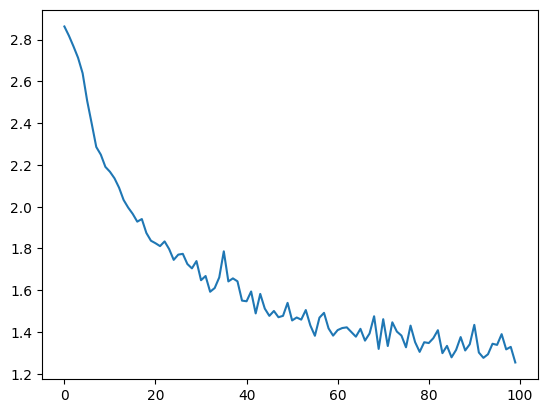

In [48]:
plt.figure()
plt.plot(all_losses)